In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import datetime
import pandas as pd
import numpy as np
import numpy.random as rd
import scipy.stats
import xlrd
import openpyxl
from numpy.linalg import inv

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

In [3]:
df_close_factors = pd.read_excel('https://raw.githubusercontent.com/lhms/Ap_quant_demo/main/df_close_factors.xlsx')
df_close_sectors = pd.read_excel('https://raw.githubusercontent.com/lhms/Ap_quant_demo/main/df_close_sectors.xlsx')
sp_sectors = pd.read_excel('https://raw.githubusercontent.com/lhms/Ap_quant_demo/main/Sectors_sp500.xlsx')
sp = pd.read_excel('https://raw.githubusercontent.com/lhms/Ap_quant_demo/main/sp.xlsx')

In [4]:
# FACTORS - MERTON PORTFOLIO

class merton_portfolio_fixed:
    def __init__(self,data,weight,cost,minimum_lot,budget):
        self.data = data # Primeira coluna: datas; segunda coluna: preços; terceira coluna: juros
        self.weight = []
        self.cost = cost #bps
        self.minimum_lot = minimum_lot
        self.budget = budget
        
        for i in range(0,len(self.data)):
            self.weight.append(weight)
        
        
        self.quantity = np.trunc(((self.budget*self.weight[0])/self.data.iloc[0,1])/self.minimum_lot)*self.minimum_lot
        self.pl = []
        self.pl.append([self.data.iloc[0,0],self.budget])
        self.turnover = []
        self.turnover.append(0)
        
        self.risk_free_hist = []
        self.risky_asset_hist = []

        self.risk_free = self.budget - self.quantity*self.data.iloc[0,1]
        
        self.risk_free_hist.append(self.risk_free)
        self.risky_asset_hist.append(self.quantity*self.data.iloc[0,1])
        

          
    def _iteration(self,i):
        
        price = self.data.iloc[i,1]
        
        actual_risky_asset = self.quantity*price
        theoretical_risky_asset = self.pl[-1][1]*self.weight[i]

        dif = actual_risky_asset - theoretical_risky_asset
        
        # Ajustando para deixar o peso fixo
        
        delta_equity = np.trunc((dif/price)/self.minimum_lot)*self.minimum_lot
        
        self.quantity -= delta_equity

        
        # Calculamos o turnover
        
        self.turnover.append(np.trunc((dif/price)/self.minimum_lot)*self.minimum_lot*price*self.cost*0.0001)
        
        # O PL do dia é o valor atual em equity + valor atual em cash - turnover
        
        self.risk_free += np.trunc((dif/price)/self.minimum_lot)*self.minimum_lot*price
        # + self.risk_free - abs(self.turnover[-1]))
        self.pl.append([self.data.iloc[i,0],self.quantity*price + self.risk_free - abs(self.turnover[-1])])
        
        self.risk_free_hist.append(self.risk_free)
        self.risky_asset_hist.append(self.quantity*price)
        
        #print(self.pl)
        
    def _apply_rebal(self):
        for i in range(1,len(self.data)):
            self._iteration(i)

            
    def _apply_interest(self):
        # Usa o FED funds como benchmark; subtrai o custo de oportunidade do risky asset, aplica no cash
        for i in range(0,len(self.risky_asset_hist)):
            int_rate = self.risky_asset_hist[i]*(1+self.data.iloc[i,2]/360)**(1/360) - self.risky_asset_hist[i]
            self.risky_asset_hist[i] -= int_rate
            
            int_rate = self.risk_free_hist[i]*(1+self.data.iloc[i,2]/360)**(1/360) - self.risk_free_hist[i]
            self.risk_free_hist[i]+=int_rate
            
            self.pl[i] = self.risk_free_hist[i] + self.risky_asset_hist[i] - abs(self.turnover[i])
        
    def get_pl(self):
        return self.pl 
    def get_weight(self):
        return self.weight 
    
class merton_portfolio_drawdown(merton_portfolio_fixed):

    def _adjust_weight(self,window,lower,upper):
        # Ajustamos o peso de acordo com o drawdown
        drawdown = np.zeros(len(self.data))
 #       w = np.zeros(len(self.data))
#        w += self.weight[0]
        for j in range(window,len(drawdown)):
            drawdown[j] = (self.data.iloc[j,1] - max(self.data.iloc[j-window:j+1,1]))/max(self.data.iloc[j-window:j+1,1])
            self.weight[j] = lower + (upper-lower)/(1+np.exp(10*drawdown[j]+2))
#        return w

# Apresentação - Demonstração de Modelos Quantitativos

O objetivo da apresentação é demonstrar de maneira introdutória a utilização de técnicas de fatores, setores econômicos e Machine Learning na construção de portfólios de ETFs com o objetivo de desenvolver estratégias de investimento.

Estrutura da apresentação:

<ol>
<li>Fatores de mercado</li>
<li>Alocação e payoffs</li>
<li>Pesos variáveis: modificando a solução de peso constante</li>
<li>Construindo um portfolio de ETFs de fatores</li>
<li>Introduzindo o aspecto econômico: rotação de setores via momemtum</li>
<li>Market timing via Machine Learning</li>
</ol>



### 1. Fatores de mercado

#### Construção de um fator
<ol>
<li>Definição do universo de ativos elegíveis</li>
<li>Definição de uma função de utilidade</li>
<li>Criação de ranking. Z-score, por exemplo</li>
<li>Definição do portfolio (long only/long-short); pesos e horizonte de rabalanceamento</li>
</ol>

Ex.: https://www.spglobal.com/spdji/en/indices/strategy/sp-500-momentum-index/#overview

Em particular, sobre o fator momentum:

Ref.: http://thierry-roncalli.com/download/Momentum_Risk_Premium.pdf

Um aspecto interessante da referência acima é a constatação de que o fator momentum possui um "payoff" particular.

### 2. Alocação e payoffs

A prescição de alocação e rebalanceamento também induz "payoffs" particulares nos portfólios. Por exemplo, na paper:

Ref.: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2465623

Dito isso, é interessante definir portfolios com perfis de alocação/rebalanceamento de modo a contrabalancear o perfil de risco e payoff dos ativos subjacentes.

Motivado pelas crises recentes, em particular os circuit-breakers gerados pelo Covid, vamos considerar duas metodologias de alocação que visam oferecer algum tipo de proteção contra eventos extremos.


<ol>
<li>Constant Proportion Portfolio Insurance (CPPI). <br>
    <br>
    Ex.: Black, F., and Perold, A. (1992), Theory of Constant Proportion Portfolio Insurance, Journal of Economic Dynamics and Control, 16(3-4), pp. 403-426.</li>
<br>
<li>Option-based Portfolio Insurance (OBPI)</li>
    <br>
    Ex.: Tail Risk Hedging: Creating Robust Portfolios for Volatile Markets (English Edition); Bhansali, Vineer <br>
    Ex.: The second leg down: Strategies for Profiting After a Market Sell-Off; Krishnan, Hari
    <br>
</ol>

Por simplicidade, vamos considerar o CPPI. A maneira mais simples de pensar no problema é considerar um portfolio com uma alocação fixa no ativo de risco (neste caso, o fator momentum, $S$) e em caixa, $C$.

\begin{equation}
\frac{dW}{W} = \alpha \frac{dS}{S} + (1-\alpha) \frac{dC}{C} = \alpha \frac{dS}{S}
\end{equation}

Se $S$ segue um Movimento Browniano Geométrico:

\begin{equation}
W = W_{0}\left(\frac{S}{S_{0}}\right)^{\alpha}exp\left(-\frac{1}{2}\alpha (1-\alpha)\sigma^{2}t \right)
\end{equation}

O payoff é uma "power option", long ou short volatilidade

<ul>
<li>$\alpha < 1$: tempo a favor (máximo em 0,5)</li>
<li>$\alpha > 1$: tempo contra </li>
</ul>

A solução que maximiza o acúmulo de riqueza ao longo do tempo quando o ativo subjacente segue um Movimento Browniano Geométrico (MBG) é dada pelo Portfolio de Merton.

Ref.: http://bibliotecadigital.fgv.br/dspace/bitstream/handle/10438/24815/fgv_dissertacao_gustavo_VF.pdf?sequence=1&isAllowed=y

Podemos atenuar o payoff similar a "long vol" do fator de momentum com um rebalanceamento baseado em proporções fixas, por exemplo.

#### Fatores individuais e alocação constante

In [5]:
def factor_ind(ETF):
    
    print("ETF - escala")
    plt.figure(figsize=(10,5))
    plt.plot(df_close_factors[ETF]/df_close_factors[ETF].iloc[0])#-df_2/df_2.iloc[0])
    plt.show()
    
    etf = merton_portfolio_drawdown(df_close_factors[['Dates',ETF]],0.5,300,10,1000000)
    etf._adjust_weight(126,0.5,1)
    etf._apply_rebal()
    pl_ = pd.DataFrame(etf.get_pl())
    
    
    print("Estratégia x ETF")
    plt.figure(figsize=(10,5))
    plt.plot(pl_.iloc[:,1]/pl_.iloc[0,1])#-df_2/df_2.iloc[0])
    #plt.plot(df_close['SPX Index']/df_close['SPX Index'].iloc[0])#-df_2/df_2.iloc[0])
    plt.plot(df_close_factors[ETF]/df_close_factors[ETF].iloc[0])#-df_2/df_2.iloc[0])
    plt.show()
    
#    print("EW - escala")
#    plt.figure(figsize=(10,5))
#    plt.plot(pl_.iloc[:,1]/pl_.iloc[0,1])#-df_2/df_2.iloc[0])
#    plt.show()
#    print("SP500 - escala")
#    plt.figure(figsize=(10,5))
#    plt.plot(df_close_factors['SPX Index']/df_close_factors['SPX Index'].iloc[0])#-df_2/df_2.iloc[0])
#    plt.show()
#    print("EW, SP500 - escala")
#    plt.figure(figsize=(10,5))
#    plt.plot(pl_.iloc[:,1]/pl_.iloc[0,1])#-df_2/df_2.iloc[0])
#    plt.plot(df_close_factors['SPX Index']/df_close_factors['SPX Index'].iloc[0])#-df_2/df_2.iloc[0])
#    plt.show()
    
#    print("EW x Fed Funds")
#    plt.figure(figsize=(10,5))
#    plt.plot(pl_.iloc[:,1]/pl_.iloc[0,1])#-df_2/df_2.iloc[0])
    #plt.plot(df_close['SPX Index']/df_close['SPX Index'].iloc[0])#-df_2/df_2.iloc[0])  
#    plt.plot(r)#-df_2/df_2.iloc[0])
#    plt.show()
    
    return

interact(factor_ind, ETF=['MTUM','VLUE','IUSG','QUAL']);

interactive(children=(Dropdown(description='ETF', options=('MTUM', 'VLUE', 'IUSG', 'QUAL'), value='MTUM'), Out…

### 3. Pesos variáveis: modificando a solução de peso constante

Na prática, não queremos manter o peso fixo o tempo inteiro, mas condicioná-lo a, digamos, o ciclo econômico em que nos encontramos. Tanto a expectativa de crescimento e a volatidade são condicionados a isso.

Para ilustrar a ideia, vamos utilizar o drawdown para realizar o timing da alocação, e combinar com um portoflio de fatores

#### Drawdown

Definição:
\begin{equation}
DD = X(T) - {\rm max}[X(t)], \ t\in (0,T)
\end{equation}

O cálculo de um drawdown através de uma janela fixa apresenta "periodicidade" o sentido fraco do termo

SP500


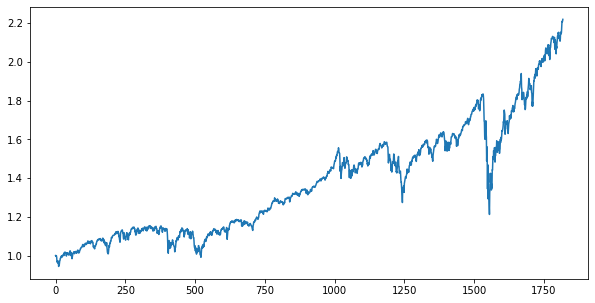

Drawdown normalizado pelo máximo da janela, tendo 1 como nível de referência


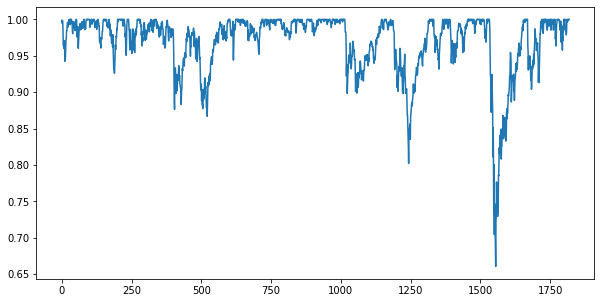

Combinação


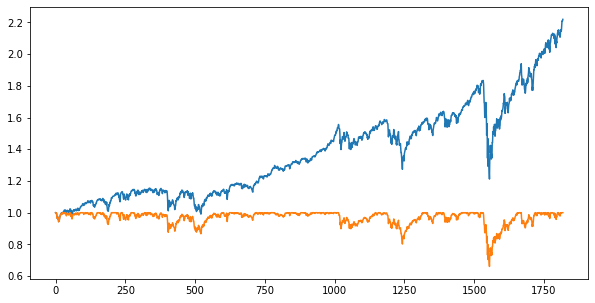

In [6]:
print("SP500")
plt.figure(figsize=(10,5))
plt.plot(df_close_factors['SPX Index'].iloc[126:len(df_close_factors)-1].reset_index(drop=True)/df_close_factors['SPX Index'].iloc[126])#-df_2/df_2.iloc[0])
plt.show()

dd = []

for i in range(126,len(df_close_factors['SPX Index'])-1):
    dd.append((df_close_factors['SPX Index'].iloc[i] - max(df_close_factors['SPX Index'].iloc[i-126:i+1]))/max(df_close_factors['SPX Index'].iloc[i-126:i+1]))
    
print("Drawdown normalizado pelo máximo da janela, tendo 1 como nível de referência")
plt.figure(figsize=(10,5))
draw = pd.Series(dd)+1
plt.plot(draw)
plt.show()

print("Combinação")
plt.figure(figsize=(10,5))
plt.plot(df_close_factors['SPX Index'].iloc[126:len(df_close_factors)-1].reset_index(drop=True)/df_close_factors['SPX Index'].iloc[126])#-df_2/df_2.iloc[0])
draw = pd.Series(dd)+1
plt.plot(draw)
plt.show()

Vamos diminuir a alocação quando nos encontramos no topo, esperando uma queda, e vamos aumentar a exposição no fundo, esperando uma recuperação. Essa abordagem é análoga ao portfolio de peso constante fixo, mas com um elemento de timing por um indicador que serve como uma "proxy" do ciclo econômico

O peso do ativo em relação ao PL da estratégia é ajustado pelo drawdown via sigmoid (função logística):

\begin{equation}
Peso = Min+ \frac{Max-Min}{1+e^{10*DD+\alpha}}
\end{equation}

O portoflio é um conjunto de fatores, cada um rebalanceado contra caixa seguindo a metodologia acima

### 4. Construindo um portfolio de ETFs de fatores

In [7]:
# Célula de inputs

print("Lookback window for drawdown calculation (days)")

def init_look_f_port(x):
    return x

look_f_port = interactive(init_look_f_port, x= widgets.BoundedIntText(
    value=126,
    min=1,
    max=252,
    step=1,
    description='Days:'))

display(look_f_port)

Lookback window for drawdown calculation (days)


interactive(children=(BoundedIntText(value=126, description='Days:', max=252, min=1), Output()), _dom_classes=…

In [8]:
print("Minimum allowed weight for the risky asset (frac)")

def init_min_w(x):
    return x

min_w = interactive(init_min_w, x= widgets.BoundedFloatText(
    value=0.5,
    min=0.1,
    max=0.9,
    step=0.01,
    description='Frac:'))

display(min_w)

Minimum allowed weight for the risky asset (frac)


interactive(children=(BoundedFloatText(value=0.5, description='Frac:', max=0.9, min=0.1, step=0.01), Output())…

In [9]:
print("Maximum allowed weight for the risky asset (frac)")

def init_max_w(x):
    return x

max_w = interactive(init_max_w, x= widgets.BoundedFloatText(
    value=1,
    min=0.1,
    max=1,
    step=0.01,
    description='Frac:'))

display(max_w)

Maximum allowed weight for the risky asset (frac)


interactive(children=(BoundedFloatText(value=1.0, description='Frac:', max=1.0, min=0.1, step=0.01), Output())…

In [10]:
#print("Hedge - short SP500 (initial) (frac)")

#def init_hedge(x):
#    return x

#initial_hedge_perc = interactive(init_hedge, x= widgets.BoundedFloatText(
#    value=0,
#    min=0,
#    max=1,
#    step=0.01,
#    description='Frac:'))

#display(initial_hedge_perc)

In [11]:
def aloc1(x):
    if x == 'Long only':
        return True
    else:
        return False

al1 = interactive(aloc1, x=['Long only','Long/short 50% PL inicial em SP500'])
display(al1)

interactive(children=(Dropdown(description='x', options=('Long only', 'Long/short 50% PL inicial em SP500'), v…

In [12]:
def factor_portfolio(ETF):
    
        lookback_f_port = look_f_port.result
        wmin_f_port = min_w.result
        wmax_f_port = max_w.result
       # initial_hedge = initial_hedge_perc.result
    
       # print(lookback_f_port,wmin_f_port,wmax_f_port,initial_hedge )
        
        assets = []
        for e in ETF:
            assets.append(merton_portfolio_drawdown(df_close_factors[['Dates',e]],0.5,300,10,1000000))


        pls = []
        for a in assets:
            a._adjust_weight(lookback_f_port,wmin_f_port,wmax_f_port)
            a._apply_rebal()
            pls.append(pd.DataFrame(a.get_pl()))

        df = pd.DataFrame()
        for pl in pls:
            df = pd.concat([df, pl.iloc[:,1]],axis=1)


        pl_ = []

        weights = np.zeros(len(df.columns))
        weights += 1/len(df.columns)

        budget = sum(df.iloc[0,:])

        quantities = (weights*budget)/np.array(df.iloc[0,:])

        pl_.append(budget)
        #
        for i in range(1,len(df)):
            actual = quantities*np.array(df.iloc[i,:])

            pl_.append(sum(actual))

            quantities = (weights*sum(actual))/np.array(df.iloc[i,:])


        pl_=pd.Series(pl_)

        pl_ = pl_/pl_.iloc[0] 
        sp = df_close_factors['SPX Index']/df_close_factors['SPX Index'].iloc[0]

        if al1.result == False:
            pl_ = pl_ - 0.5*sp  
        

        print("Estratégia - escala")
        plt.figure(figsize=(10,5))
        plt.plot(pl_)#-df_2/df_2.iloc[0])
        plt.show()
        print("SP500 - escala")
        plt.figure(figsize=(10,5))
        plt.plot(df_close_factors['SPX Index']/df_close_factors['SPX Index'].iloc[0])#-df_2/df_2.iloc[0])
        plt.show()
        print("Estratégia, SP500 - escala")
        plt.figure(figsize=(10,5))
        plt.plot(pl_)#-df_2/df_2.iloc[0])
        plt.plot(df_close_factors['SPX Index']/df_close_factors['SPX Index'].iloc[0])#-df_2/df_2.iloc[0])
        plt.show()

    #    print("EW x Fed Funds")
    #    plt.figure(figsize=(10,5))
    #    plt.plot(pl_.iloc[:,1]/pl_.iloc[0,1])#-df_2/df_2.iloc[0])
        #plt.plot(df_close['SPX Index']/df_close['SPX Index'].iloc[0])#-df_2/df_2.iloc[0])  
    #    plt.plot(r)#-df_2/df_2.iloc[0])
    #    plt.show()


interact(factor_portfolio, ETF= widgets.SelectMultiple(
    options=['MTUM','VLUE','IUSG','QUAL'],
    value = ['MTUM'],
    description='Factors'));

interactive(children=(SelectMultiple(description='Factors', index=(0,), options=('MTUM', 'VLUE', 'IUSG', 'QUAL…

### 5. Introduzindo o aspecto econômico: rotação de setores via momemtum

Uma forma de envolver o aspecto macroeconômico é escolher fatores baseados em um ranking de momentum.

\begin{equation}
M = sign(Retorno\ passado \ em \ janela \ \Delta t) ∗ [\% retornos \ negativos −\% retornos \ positivos]
\end{equation}

Obs.: Sejam $t_{1}$ e $t_{2}$ dois horizontes de tempo. A janela é calculada como retornos de -252-21 dias até -21 dias. Excluímos os retornos de $t_{2}$, no caso, o mês mais recente.

Ref: Quantitative momentum: a practitioner’s guide to building a momentum-based stock selection system; Wesley R. Gray, Jack R. Vogel

In [13]:
class sector_rotation_fixed_weight:
    def __init__(self,data,number_of_sectors,cost,minimum_lot,budget,window1,window2,horizon):
        self.data = data # Primeira coluna: datas; a partir da segunda coluna: preços, última: juros
        self.number_of_sectors = number_of_sectors
        self.window1 = window1
        self.window2 = window2
        self.horizon = horizon
        self.weight = []
        self.cost = cost #bps
        self.minimum_lot = minimum_lot
        self.budget = budget
        self.quantity = np.zeros(len(self.data.columns)-2)
        
        w = np.zeros(number_of_sectors)
        
        for i in range(0,len(self.data)):
            self.weight.append(w)
        
        for i in range(0,number_of_sectors):
            self.quantity[i] = np.trunc(((self.budget*self.weight[0][i])/self.data.iloc[0,i+1])/self.minimum_lot)*self.minimum_lot
        self.pl = []
        self.pl.append([self.data.iloc[0,0],self.budget])
        self.turnover = []
        self.turnover.append(0)
        
        self.scores = []
        
    def _ranking(self,i): #Tem que vir depois do _iteração
        scores = []
        
        for j in range(1,len(self.data.columns)-1):
            hist = self.data.iloc[i-self.window1-self.window2:i-self.window2+1,j]
            hist = list(hist.astype(float).apply(np.log).diff().dropna(how='any').reset_index(drop=True))
            
            signal = sum(hist)/abs(sum(hist))
            
            neg_count = len(list(filter(lambda x: (x < 0), hist)))/len(hist)
            pos_count = len(list(filter(lambda x: (x >= 0), hist)))/len(hist)
            
            scores.append([signal*(pos_count-neg_count),j])
            scores.sort(key=lambda tup: tup[0], reverse=True)
        
        # Já temos os scores ordenados do maior para o menor
        norm = 0
        for j in range(0,len(scores)):
            if j<self.number_of_sectors:
                scores[j][0] = 1/self.number_of_sectors # Peso igual
 #               scores[j][0] = 1/(j+1)**2
#                norm+=1/(j+1)**2
            else:
                scores[j][0] = 0
                
#        for j in range(0,len(scores)): 
#            scores[j][0] = scores[j][0]/norm
        
        # Devolvendo para a ordem inicial, baseada em colunas
        
        scores.sort(key=lambda tup: tup[1])
        # Neste ponto, os scores correspondem aos pesos relativos. Vamos converter para quantidade de ações,
        # calcular o turnover, e redefinir o vetor de quantidades.
        
        q = np.zeros(len(self.data.columns)-2)
        t = 0
        for j in range(0,len(scores)):
            q[j] = np.trunc(((self.pl[-1][1]*scores[j][0])/self.data.iloc[i,j+1])/self.minimum_lot)*self.minimum_lot
            dif = self.quantity[j]-q[j]
            t+=abs(np.trunc((dif/self.data.iloc[i,j+1])/self.minimum_lot)*self.minimum_lot*self.data.iloc[i,j+1]*self.cost*0.0001)
                
        
        self.turnover.append(t)

        self.pl[-1][1] -= t
        
        self.quantity = q
            
            
    def _iteration(self,i):
        
        price = np.array(self.data.iloc[i,1:-1])

        self.pl.append([self.data.iloc[i,0],sum(self.quantity*price)])
        
        
    def _apply_rebal(self):
        for i in range(self.window1+self.window2,len(self.data)):
            if i == self.window1+self.window2:
                self._ranking(i)
            else: 
                self._iteration(i)
                if i%self.horizon==0:
                    self._ranking(i)
            #print(self.quantity)
    
    def get_pl(self):
        return self.pl 
    def get_quantities(self):
        return self.quantity 

Lista de ETFs usados: 'XLK', 'XLC', 'XLY', 'XLI', 'XLB', 'XLF', 'XLE', 'XLV', 'XLP', 'XLRE', 'XLU'

In [14]:
# Célula de inputs

print("Lookback window 1 (days)")

def init_look_f_port(x):
    return x

look_f_port1 = interactive(init_look_f_port, x= widgets.BoundedIntText(
    value=63,
    min=1,
    max=252,
    step=1,
    description='Days:'))

display(look_f_port1)

Lookback window 1 (days)


interactive(children=(BoundedIntText(value=63, description='Days:', max=252, min=1), Output()), _dom_classes=(…

In [15]:
# Célula de inputs

print("Lookback window 2 (days)")

def init_look_f_port(x):
    return x

look_f_port2 = interactive(init_look_f_port, x= widgets.BoundedIntText(
    value=21,
    min=1,
    max=252,
    step=1,
    description='Days:'))

display(look_f_port2)

Lookback window 2 (days)


interactive(children=(BoundedIntText(value=21, description='Days:', max=252, min=1), Output()), _dom_classes=(…

In [16]:
# Célula de inputs

print("Rebalancing horizon (days)")

def init_look_f_port(x):
    return x

horizon = interactive(init_look_f_port, x= widgets.BoundedIntText(
    value=21,
    min=1,
    max=252,
    step=1,
    description='Days:'))

display(horizon)

Rebalancing horizon (days)


interactive(children=(BoundedIntText(value=21, description='Days:', max=252, min=1), Output()), _dom_classes=(…

In [17]:
print("PL(t=0) Hedge (short SP500)")

def init_min_w(x):
    return x

hedge_sector = interactive(init_min_w, x= widgets.BoundedFloatText(
    value=0.5,
    min=0,
    max=1,
    step=0.01,
    description='Frac:'))

display(hedge_sector)

PL(t=0) Hedge (short SP500)


interactive(children=(BoundedFloatText(value=0.5, description='Frac:', max=1.0, step=0.01), Output()), _dom_cl…

In [18]:
# Célula de inputs

print("N ativos")

def ativos(x):
    return x

a = interactive(ativos, x= widgets.BoundedIntText(
    value=3,
    min=1,
    max=11,
    step=1,
    description='N de ativos:'))

display(a)

N ativos


interactive(children=(BoundedIntText(value=3, description='N de ativos:', max=11, min=1), Output()), _dom_clas…

In [19]:
def aloc(x):
    if x == 'Long only':
        return True
    else:
        return False

al = interactive(aloc, x=['Long only','Long/short SP500'])
display(al)

interactive(children=(Dropdown(description='x', options=('Long only', 'Long/short SP500'), value='Long only'),…

In [20]:
def f_sector(b):
    
    with output:
        clear_output()
        ETF=['XLK','XLC','XLY','XLI','XLB','XLF','XLE','XLV','XLP','XLRE','XLU']
    #    print("ETF - escala")
    #    plt.figure(figsize=(10,5))
    #    plt.plot(df_close_sectors[ETF]/df_close_sectors[ETF].iloc[0])#-df_2/df_2.iloc[0])
    #    plt.show()


        etf = sector_rotation_fixed_weight(pd.concat([df_close_sectors['Dates'],df_close_sectors.iloc[:,3:]],axis=1),int(a.result),300,
                                           10,1000000,look_f_port1.result,look_f_port2.result,horizon.result)
        #etf._adjust_weight(126,0.5,1)
        etf._apply_rebal()
        pl_ = pd.DataFrame(etf.get_pl())

        if al.result == False:

            pl_hedge = pl_.iloc[:,1]/pl_.iloc[0,1] - hedge_sector.result*sp.iloc[-len(pl_):,1].reset_index(drop=True)/sp.iloc[-len(pl_),1]
            pl_hedge += 1 - pl_hedge.iloc[0]
        else:
            pl_hedge = pl_.iloc[:,1]/pl_.iloc[0,1]


        print("PL - escala")
        plt.figure(figsize=(10,5))
        #plt.plot(pl_.iloc[:,1]/pl_.iloc[0,1])#-df_2/df_2.iloc[0])
        plt.plot(pl_hedge)#/pl_hedge.iloc[0])
        plt.show()
        print("Ativo - escala")
        plt.figure(figsize=(10,5))
        plt.plot(sp.iloc[-len(pl_):,1].reset_index(drop=True)/sp.iloc[-len(pl_),1])#-df_2/df_2.iloc[0])
        plt.show()

        print("PL e ativo - escala")
        plt.figure(figsize=(10,5))
        #plt.plot(pl_.iloc[:,1]/pl_.iloc[0,1])#-df_2/df_2.iloc[0])
        plt.plot(pl_hedge)#/pl_hedge.iloc[0])
        plt.plot(sp.iloc[-len(pl_):,1].reset_index(drop=True)/sp.iloc[-len(pl_),1])#-df_2/df_2.iloc[0])
        plt.show()

    #    print("EW x ETF")
    #    plt.figure(figsize=(10,5))
    #    #plt.plot(pl_.iloc[:,1]/pl_.iloc[0,1])#-df_2/df_2.iloc[0])
    #    plt.plot(pl_hedge/pl_hedge.iloc[0])
        #plt.plot(df_close['SPX Index']/df_close['SPX Index'].iloc[0])#-df_2/df_2.iloc[0])
    #    plt.plot(df_close_sectors[ETF].iloc[-len(pl_):].reset_index(drop=True)/df_close_sectors[ETF].iloc[-len(pl_)])#-df_2/df_2.iloc[0])
        plt.show()
    #
        return


button = widgets.Button(description="OK")
output = widgets.Output()


display(button, output)

button.on_click(f_sector)

#start_button = widgets.Button(description='OK')
# Trocar por um botão de OK
#interact(f, ETF=['XLK','XLC','XLY','XLI','XLB','XLF','XLE','XLV','XLP','XLRE','XLU']);
#display(start_button)
#start_button.on_click(f(ETF))

Button(description='OK', style=ButtonStyle())

Output()

### 6. Market timing via Machine Learning

A utilidade de ML é a possibilidade de combinar fatores/indicadores que, isoladamente, possuem uma capacidade preditiva limitada em algo que apresenta uma performance muito superior.

Vamos construir uma base de dados envolvendo os índices de setores disponíveis em https://www.spglobal.com/spdji/en/index-family/strategy/ . O motivo é simplesmente expandir o histórico (os ETFs usados anteriormente tem um horizonte mais limitado) para treinamos uma Decision Tree

Os índices usados são:

<ul>
<li>Consumer_discretionary</li>
<li>Consumer_staples</li>
<li>Energy</li>
<li>Financials</li>
<li>Health Care</li>
<li>Industrials</li>
<li>Tech</li>
<li>Materials</li>
<li>Communication_services</li>
<li>Utilities</li>
<li>Commodities_GSCI (índices de commodities)</li>
<li>DJ_FXCM_Dollar_Index (índice de moedas)</li>
<li>SP500</li>
</ul>

E os indicadores construídos são:

<ul>
<li>Momentum, janela 126</li>
<li>Drawdown, janela 126</li>
</ul>

Construção da resposta do algoritmo:

<ul>
    <li>Retorno do ativo 21 dias adiante</li>
</ul>

Backtest: últimos 504+21 dias (final de 2019, 2020 e parte de 2021). A probabilidade retornada pelo algoritmo é utilizada para construir o peso do ativo, em um portfolio caixa + ativo, segundo:

\begin{equation}
Peso = 0.1 + \frac{0.9}{1+e^{-Prob}}
\end{equation}

In [29]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV


# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=30, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = RandomForestClassifier(max_depth=depth,random_state=0,n_estimators =5)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()
    
def run_single_tree(X_train, y_train, X_test, y_test, depth):
    model = RandomForestClassifier(max_depth=depth,random_state=0,n_estimators =5).fit(X_train, y_train)
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)
    print('Single tree depth: ', depth)
    print('Accuracy, Training Set: ', round(accuracy_train*100,5), '%')
    print('Accuracy, Test Set: ', round(accuracy_test*100,5), '%')
    return accuracy_train, accuracy_test

def name_sector(name):
    
    sp_feat = pd.read_excel("sp_feat.xlsx")

#    names = list(sp_sectors.columns)[1:]
    df_close_factors = pd.read_excel('https://raw.githubusercontent.com/lhms/Ap_quant_demo/main/df_close_factors.xlsx')
    df_close_sectors = pd.read_excel('https://raw.githubusercontent.com/lhms/Ap_quant_demo/main/df_close_sectors.xlsx')
    sp_sectors = pd.read_excel('https://raw.githubusercontent.com/lhms/Ap_quant_demo/main/Sectors_sp500.xlsx')
    sp = pd.read_excel('https://raw.githubusercontent.com/lhms/Ap_quant_demo/main/sp.xlsx')
    sp_feat = pd.read_excel("https://raw.githubusercontent.com/lhms/Ap_quant_demo/main/sp_feat.xlsx")
    
    sp_sectors_ = sp_sectors.copy()
    sp_sectors_.iloc[:,1:] = sp_sectors_.iloc[:,1:].apply(np.log).diff().dropna(how='any').reset_index(drop=True)

    sp_feat = sp_feat.iloc[126:,:]
    sp_sectors_ = sp_sectors_.iloc[126:,:]
    sp_sectors = sp_sectors.iloc[126:,:]

    sp_feat = sp_feat.reset_index(drop=True)
    sp_sectors_ = sp_sectors_.reset_index(drop=True)
    sp_sectors = sp_sectors.reset_index(drop=True)
        
    forward = 21
    initial = 0

    X = sp_feat.iloc[initial:len(sp_feat)-504-forward,:].reset_index(drop=True)
    backtest = sp_feat.iloc[len(sp_feat)-504-forward:,:].reset_index(drop=True)


    resp = []
    
    cols = list(sp_sectors.columns)
    position = cols.index(name)
    #print(position)
    
    for i in range(initial,len(sp_feat)-504-forward):
        if sum(sp_sectors_[name].iloc[i:i+forward])>0:
            resp.append(1)
        else:
            resp.append(0)

    # fitting trees of depth 1 to 24
    sm_tree_depths = range(1,25)
    sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X, pd.Series(resp), sm_tree_depths)

    # plotting accuracy
    plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                                       'Accuracy per decision tree depth on training data')

    idx_max = sm_cv_scores_mean.argmax()
    sm_best_tree_depth = sm_tree_depths[idx_max]
    sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
    sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
    print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
              sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

    if sm_best_tree_depth == 1:
        sm_best_tree_depth +=1
        
    #clf = tree.DecisionTreeClassifier(max_depth=sm_best_tree_depth,random_state=0)
    clf = RandomForestClassifier(max_depth=sm_best_tree_depth, random_state=0,n_estimators =5)
    
    #clf = LogisticRegressionCV(cv=20,random_state=0,max_iter =1000)
    clf = clf.fit(X, pd.Series(resp))

    pred = clf.predict_proba(np.matrix(backtest))
    b = sp_sectors_[name].iloc[len(sp_sectors_)-504-forward:].reset_index(drop=True)


    pred_ = pd.DataFrame(pred)
    plt.figure(figsize=(10,5))
    plt.plot(pred_.iloc[:,1])
    plt.show()
    plt.figure(figsize=(10,5))
    plt.plot(b.cumsum())
    plt.show()
    plt.figure(figsize=(10,5))
    plt.plot(pred_.iloc[:,1])
    plt.plot(b.cumsum())
    plt.show()

    ret = []

    for i in range(0,len(b)-1):
        ret.append((0.1 + 0.9/(1+np.exp(-pred_.iloc[i,1]**2)))*b.iloc[i+1])

    plt.figure(figsize=(10,5))
    plt.plot(pd.Series(ret[forward:]).cumsum())
    plt.plot(b.iloc[forward:].reset_index(drop=True).cumsum())
    plt.show()

    return


nm = interactive(name_sector, name=['Consumer_discretionary', 'Consumer_staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Tech', 'Materials', 'Communication_services', 'Utilities', 'Commodities_GSCI', 'SP500', 'DJ_FXCM_Dollar_Index'])
display(nm)

interactive(children=(Dropdown(description='name', options=('Consumer_discretionary', 'Consumer_staples', 'Ene…